In [31]:
import pandas
import glob
import os
import pylab
import numpy
import subprocess
from astropy.io import ascii
from astropy.time import Time
from scipy.stats import sigmaclip


Here I define Stuart's trender.py wrappter to use it in Jupter Notebook

In [32]:
def trender(start, dur, item):
    command = ['/gpfs/slac/lsst/fs2/u1/devel/marshall/mutils/bin/trender.py',
         '--force --start {}UTC --dur {} --text -- {}'.format(start.isot,dur,item) ]
    trend = subprocess.run( " ".join(command), stdout=subprocess.PIPE,shell=True)
    return ascii.read(trend.stdout.decode('utf-8'),
               names=[
                   'time (ms)',
                   'value',
                   'unit',
                   'channel CCS path',
                   'iso-8601 Date'
               ])

Here I define a function to make a plot of gain change

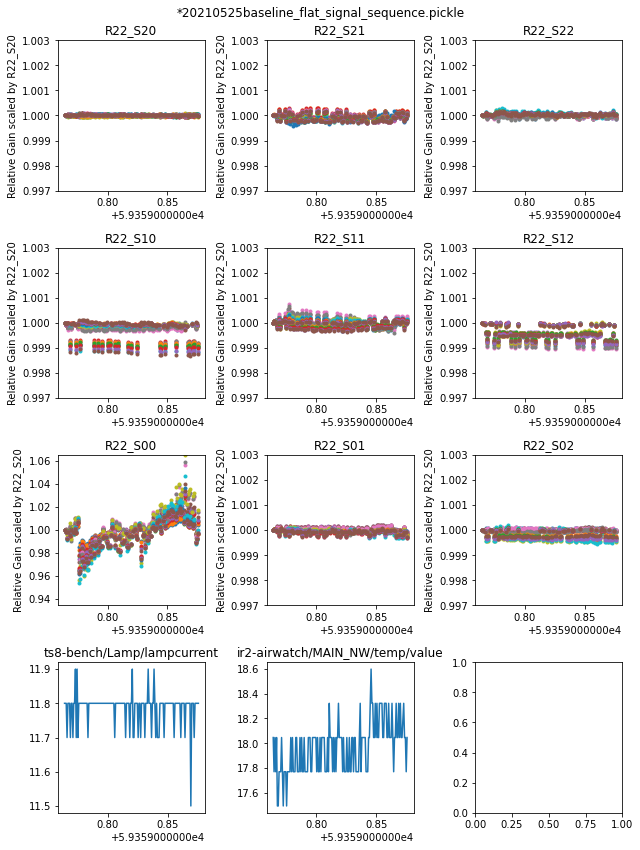

In [75]:
def gainchange( path ):
    pickles = glob.glob(path)
    results = {}
    for apickle in pickles:
        results.update(
            {
                "_".join(os.path.basename(apickle).split("_")[:2])
                : pandas.read_pickle(apickle)
            }
        )

    fig, axs = pylab.subplots(4, 3, figsize=(9,12),facecolor='w')
    axes = axs.flatten()
    
    for j, asensor in enumerate(
            [
                "S20", "S21", "S22",
                "S10", "S11", "S12",
                "S00", "S01", "S02"
            ]
    ):
        ax = axes[j]
        norm = numpy.median([ results["R22_S20"]["amp{:02d}".format(k)] for k in range(1,17) ],axis=0)
        norm /= norm.mean()
#        print(norm)
        for i in range( 1,17 ):        
            thesensorname="R22_{}".format(asensor)
            mjd = results[thesensorname]["mjd"]            
            y = results[thesensorname]["amp{:02d}".format(i)]/norm
            ax.set_title(thesensorname)
            ax.set_ylabel("Relative Gain scaled by R22_S20")
            ax.plot(mjd,y/y[0],".")
        dy = max(0.003, (y/y[0]).std()*5)
        ax.set_ylim(1-dy,1+dy)
            
    dt1 = Time(mjd.min(),format="mjd")
    dt2 = Time(mjd.max(),format="mjd")
    m = "{:.0f}m".format((dt2.datetime-dt1.datetime).total_seconds()/60)

    for i, name in enumerate([
        "ts8-bench/Lamp/lampcurrent",
        "ir2-airwatch/MAIN_NW/temp/value"
        ]):
        trend = trender(dt1,m, name)
        ax = axes[i+j+1]
        ax.plot(
            Time(trend["time (ms)"]/1000,format="unix").mjd,
            trend["value"],
            label = name
        )
        ax.set_title(name)

    fig.suptitle(os.path.basename(path))
    fig.tight_layout()

gainchange("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*20210525baseline_flat_signal_sequence.pickle")

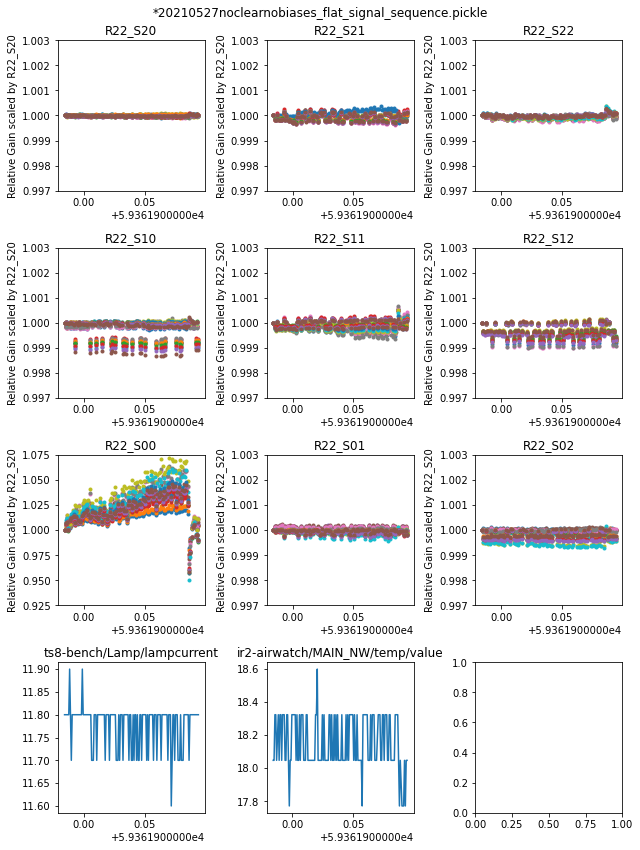

In [76]:
gainchange("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*20210527noclearnobiases_flat_signal_sequence.pickle")

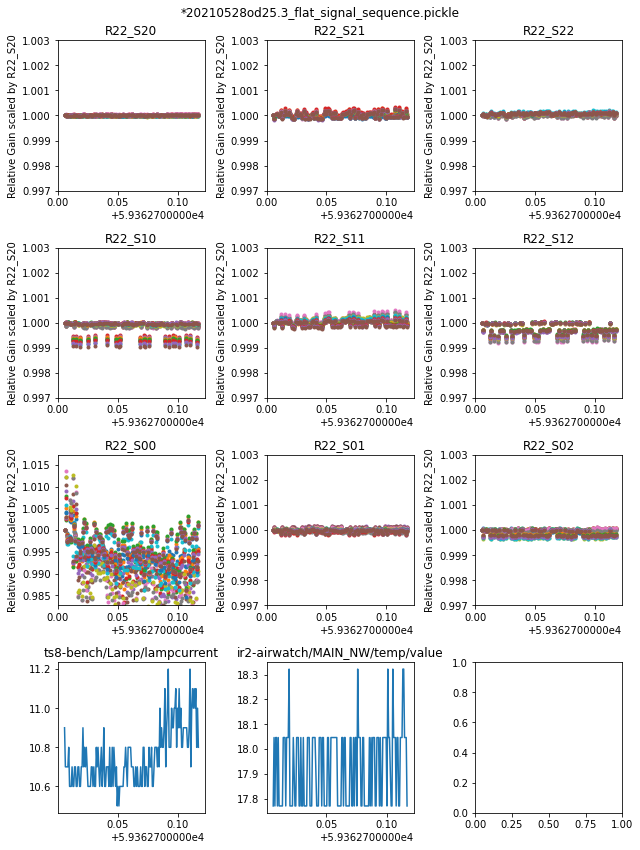

In [77]:
gainchange("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*20210528od25.3_flat_signal_sequence.pickle")

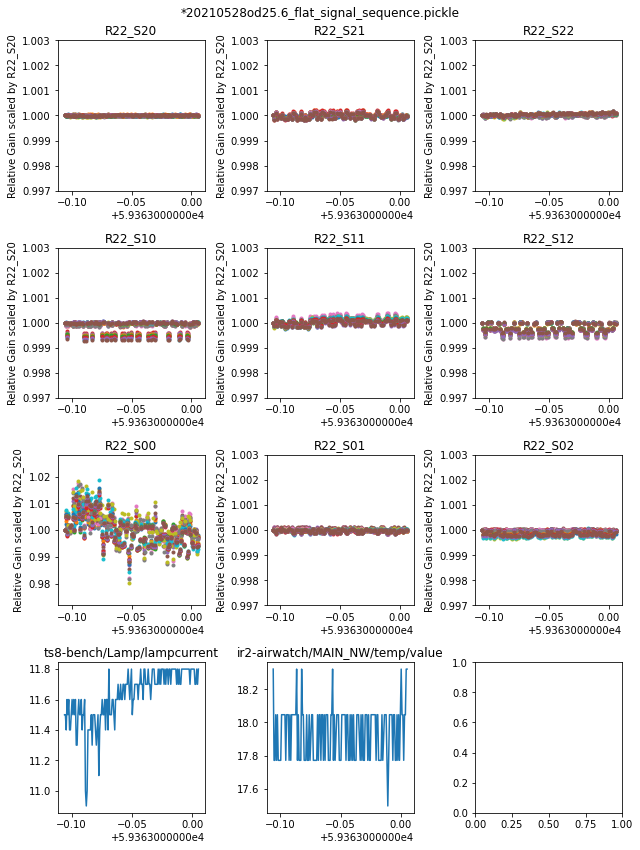

In [78]:
gainchange("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*20210528od25.6_flat_signal_sequence.pickle")

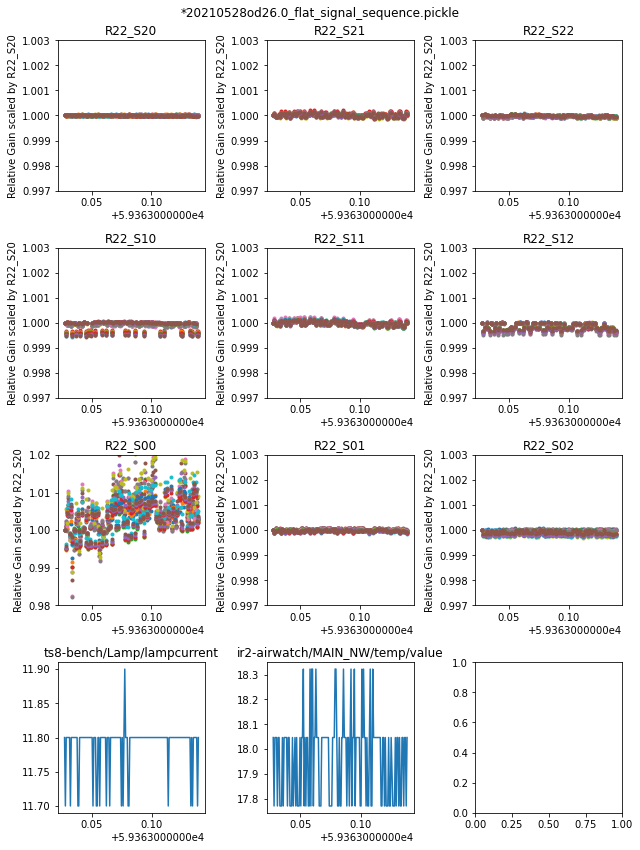

In [79]:
gainchange("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*20210528od26.0_flat_signal_sequence.pickle")

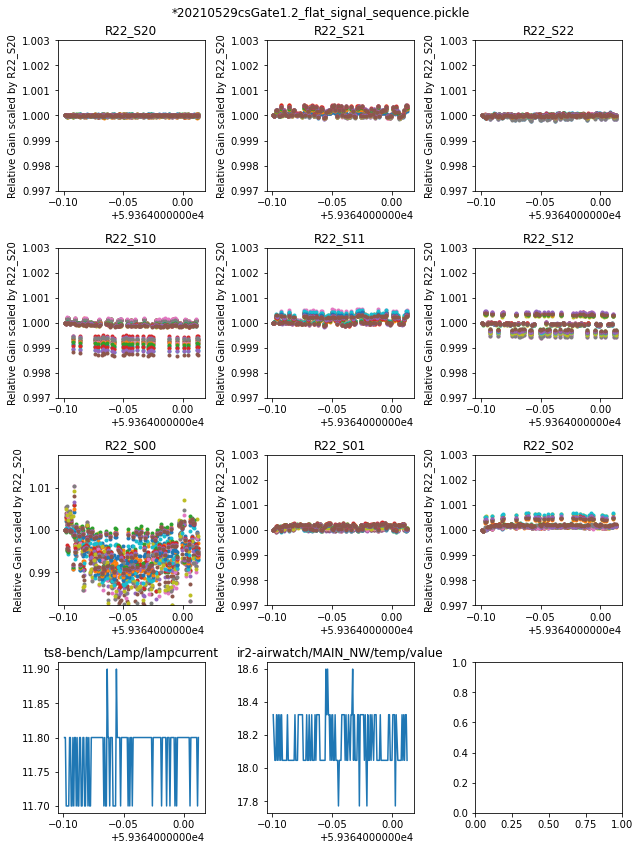

In [80]:
gainchange("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*20210529csGate1.2_flat_signal_sequence.pickle")

Photodiode trending

-1.8261783163636365e-08 1.0061400432943479e-10
-1.7606851241830066e-08 1.4516516015736124e-10
-1.7552736045751638e-08 1.4068606411632448e-10


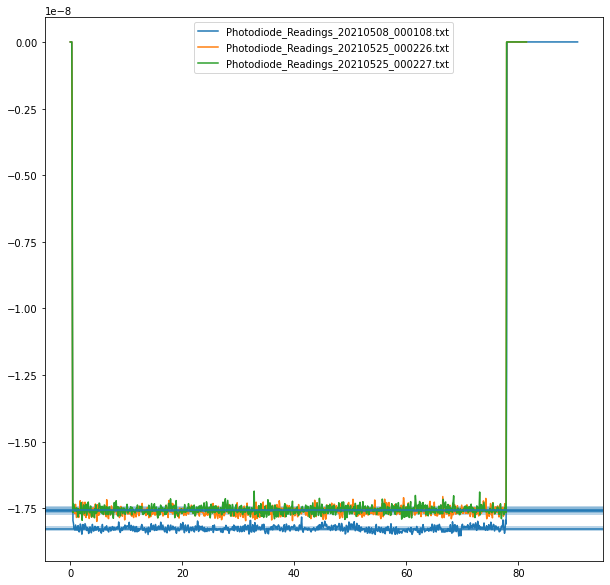

In [35]:
fig = pylab.figure(figsize=(10,10))

for apath in [
    "/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210508/TS_C_20210508_000108/Photodiode_Readings_20210508_000108.txt",
    "/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210525baseline2/TS_C_20210525_000226/Photodiode_Readings_20210525_000226.txt",
    "/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210525baseline2/TS_C_20210525_000227/Photodiode_Readings_20210525_000227.txt",
#    "/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210527/TS_C_20210527_000016/Photodiode_Readings_20210527_000016.txt"
    ]:
    f=numpy.loadtxt(apath)
    x, y = f.T
    pylab.plot(x,y,label=os.path.basename(apath))
    Y = y[numpy.where( y < -1.5e-8 )]
    pylab.axhline(Y.mean())
    pylab.axhspan(Y.mean()-Y.std(),Y.mean()+Y.std(),alpha=0.3)
    print(Y.mean(), Y.std())
pylab.legend()

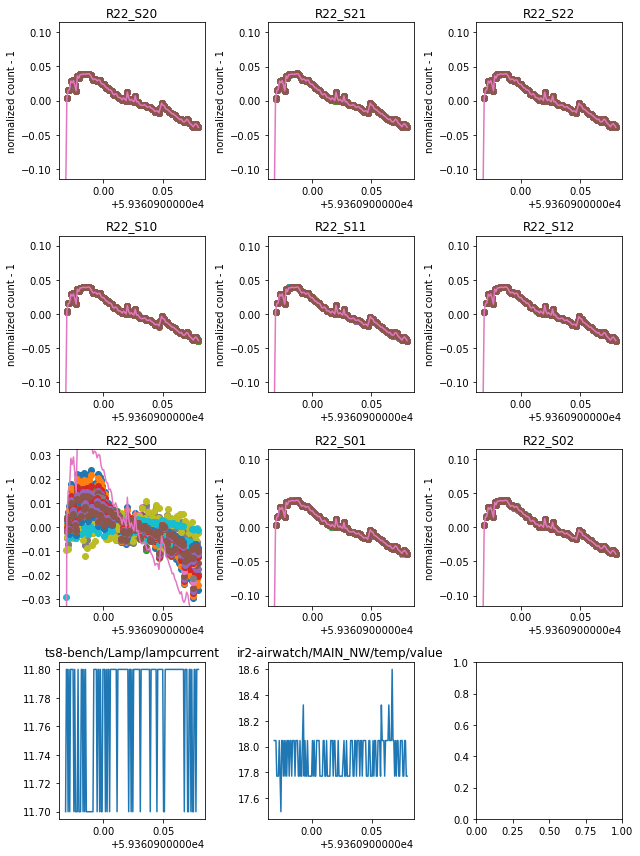

In [39]:

def main(path):
    pickles = glob.glob(path)

    results = {}
    for apickle in pickles:
        results.update(
            {
                "_".join(os.path.basename(apickle).split("_")[:2])
                : pandas.read_pickle(apickle)
            }
        )

    #fig = pylab.figure()
    fig, axs = pylab.subplots(4, 3, figsize=(9,12),facecolor='w')
    axes = axs.flatten()
    for j, asensor in enumerate(
            [
                "S20", "S21", "S22",
                "S10", "S11", "S12",
                "S00", "S01", "S02"
            ]
    ):
        ax = axes[j]
        for i in range( 1,17 ):
            thesensorname="R22_{}".format(asensor)
            y = results[thesensorname]["amp{:02d}".format(i)]
            y = y/numpy.median(y)-1
            ax.set_title(thesensorname)
            ax.set_ylabel("normalized count - 1")
            c, low, upp = sigmaclip(y)
            s = c.std()
            ax.set_ylim(-5*s,5*s)
            ax.plot(results[thesensorname]["mjd"],y,"o")
        y = results[thesensorname]["flux"]
        y = y/numpy.median(y)-1        
        mjd = results[thesensorname]["mjd"]
        ax.plot(mjd,y)


    dt1 = Time(mjd.min(),format="mjd")
    dt2 = Time(mjd.max(),format="mjd")
    m = "{:.0f}m".format((dt2.datetime-dt1.datetime).total_seconds()/60)

    for i, name in enumerate([
        "ts8-bench/Lamp/lampcurrent",
        "ir2-airwatch/MAIN_NW/temp/value"
        ]):
        trend = trender(dt1,m, name)
        ax = axes[i+j+1]
        ax.plot(
            Time(trend["time (ms)"]/1000,format="unix").mjd,
            trend["value"],
            label = name
        )
        ax.set_title(name)
    fig.tight_layout()

main("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*_TS8-20210526baseline3*.pickle")

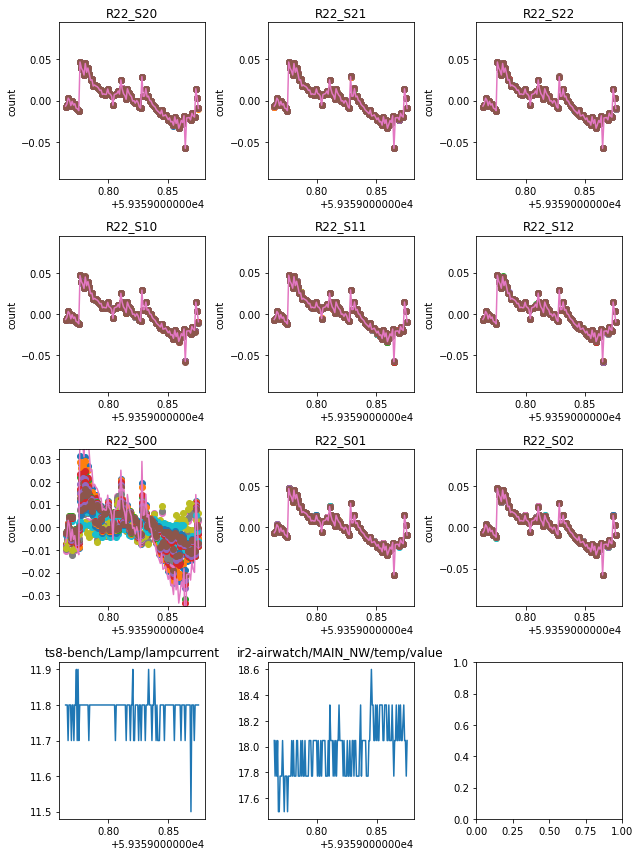

In [22]:
main("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*_TS8-20210525baseline_*.pickle")

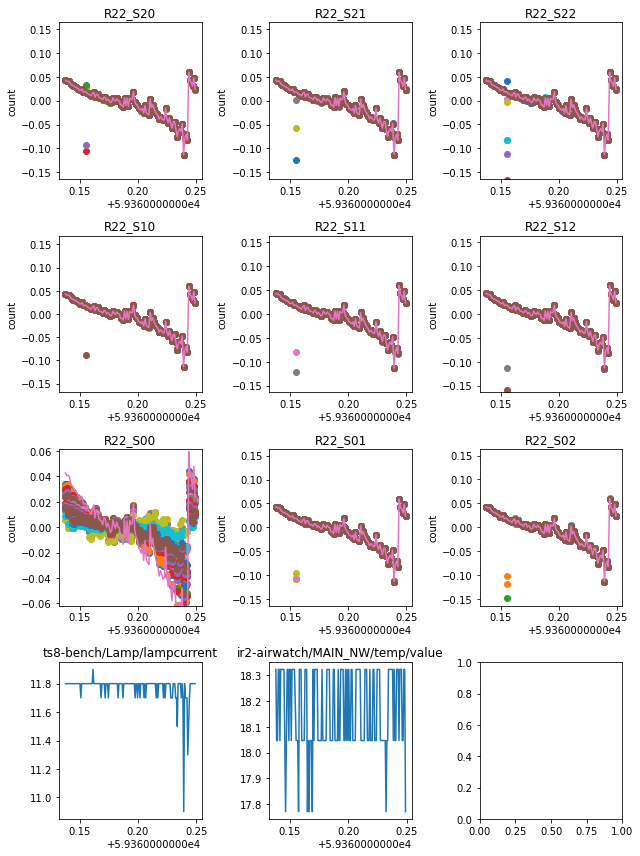

In [23]:
main("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*_TS8-20210525baseline2_*.pickle")

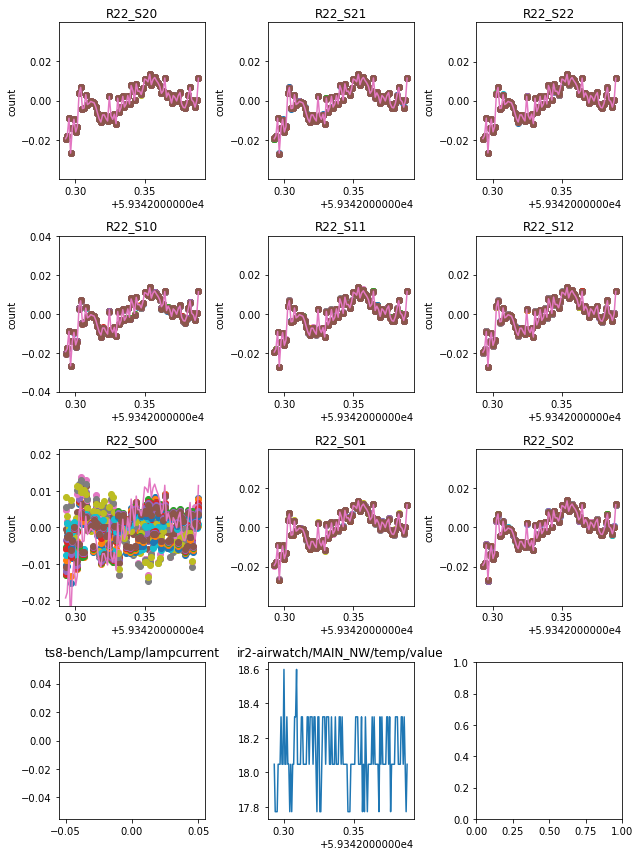

In [24]:
main("/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/*_TS8-20210508_*.pickle")